# Heatmaps

This notebook analyses the data pre-processed in the `ws2_2_topic_modelling` notebook. 

Specifically, we look at:
1. The number of articles published every day. We inspect how the average number of publications has been affected due to COVID-19.
2. The number of articles published every day, <strong>per topic</strong>. We repeat the same experiment as the previous one but we go one step further and look at the impact of COVID on each separate topic.
3. The sentiments conveyed in the articles published every day, <strong>per topic</strong>. We repeat once again the same experiment but we go even further by looking at the evolution of the sentiments in each separate topic.


#### Input:

ws_2_article_topic_<strong>XX</strong>.csv produced by the `ws2_2_topic_modelling` notebook:

where <strong>XX</strong> is the optimal number of topics. The dataset is structured in 9 columns: an article ID, an article (original text), a number of words (in the article), a cleaned version of the text, the number of words (in the cleaned text), a publication date, a dominant topic in the article, the weight of the topic, a set of keywords related to the topic, and a topic label.
 
#### Output:

The code displays several plots and heatmaps to illustrate the results of each experiment.

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

### Configuration parameters

In [103]:
# The path to the output folder where all the outputs will be saved
output_path = "/project_data/data_asset"

In [104]:
num_topics = 6

articles = pd.read_csv(f"{output_path}/ws_2_article_topic_{num_topics}.csv")
articles.head()

,article_id,article,date,n_words,article_clean,n_words_clean,dominant_topic,weight,keywords,topic_label
0,0,an acquaintance in Post-Polio >Syndrome This a...,2020-01-01,160,acquaintance post polio syndrome apparently ne...,64,5,0.5039,"['health, disease, medical, patient, year, inf...",label_6
1,1,"homore in high school. Before that, I used to ...",2020-01-02,81,homore high school bloody nose nighttime asthm...,26,0,0.4987,"['science, problem, well, pain, much, thing, d...",label_1
2,2,"7:26 GMT On 5 Apr 93 23:27:26 GMT, (Vida Morku...",2020-01-03,280,gmt apr gmt vida morkunas vida inner ear probl...,123,0,0.9729,"['science, problem, well, pain, much, thing, d...",label_1
3,3,tes about heat shock proteins (HSP's) and DNA....,2020-01-04,159,te heat shock protein hsp dna hate derogatory ...,55,0,0.5005,"['science, problem, well, pain, much, thing, d...",label_1
4,4,now mapping the human genome. We will > then s...,2020-01-05,290,human genome manipulation genome genetic engin...,119,1,0.2706,"['study, food, msg, people, blood, human, arti...",label_2


## Experiment 1: Number of articles published every day

In [105]:
articles_per_day = articles[["date", "topic_label"]].copy()
articles_per_day["n_articles"] = 1
articles_per_day = articles_per_day.groupby("date").agg({
    "topic_label": lambda x: list(x),
    "n_articles": lambda x: sum(x)
}).reset_index(drop=False)
articles_per_day["topic_label"] = articles_per_day["topic_label"].apply(lambda x: list(set(x)))
articles_per_day["n_topics"] = articles_per_day["topic_label"].apply(len)
articles_per_day.head()

,date,topic_label,n_articles,n_topics
0,2020-01-01,[label_6],1,1
1,2020-01-02,[label_1],1,1
2,2020-01-03,[label_1],1,1
3,2020-01-04,[label_1],1,1
4,2020-01-05,[label_2],1,1


In [ ]:
articles_per_day.plot(x="date", 
                      y="n_articles", 
                      figsize=(20, 10))

In [ ]:
rolling_window_length = 10

articles_per_day_rolling = articles_per_day.copy()
articles_per_day_rolling["n_articles"] = articles_per_day_rolling["n_articles"].rolling(window=rolling_window_length).mean()
articles_per_day_rolling.plot(x="date", 
                              y="n_articles", 
                              figsize=(20, 10))

## Experiment 2: Number of articles published every day, per topic.

In [ ]:
all_topics = pd.read_csv(f"{output_path}/ws_2_article_topic_{num_topics}.csv",
                         usecols=["topic_label"])
all_topics = all_topics["topic_label"].unique()

In [109]:
articles_per_day["topic_occurrences"] = articles_per_day["topic_label"].apply(lambda x: [(elem, x.count(elem)) for elem in all_topics])
for topic_name in all_topics:
    articles_per_day[topic_name] = articles_per_day["topic_occurrences"].apply(lambda x: [elem[1] for elem in x if elem[0] == topic_name])
    articles_per_day[topic_name] = articles_per_day[topic_name].apply(lambda x: x[0] if len(x) > 0 else 0)
articles_per_day.drop(["topic_label", "n_articles", "n_topics", "topic_occurrences"], axis=1, inplace=True)
articles_per_day.set_index("date", drop=True, inplace=True)
articles_per_day.head()

,label_6,label_1,label_2,label_4,label_3,label_5
date,,,,,,
2020-01-01,1,0,0,0,0,0
2020-01-02,0,1,0,0,0,0
2020-01-03,0,1,0,0,0,0
2020-01-04,0,1,0,0,0,0
2020-01-05,0,0,1,0,0,0


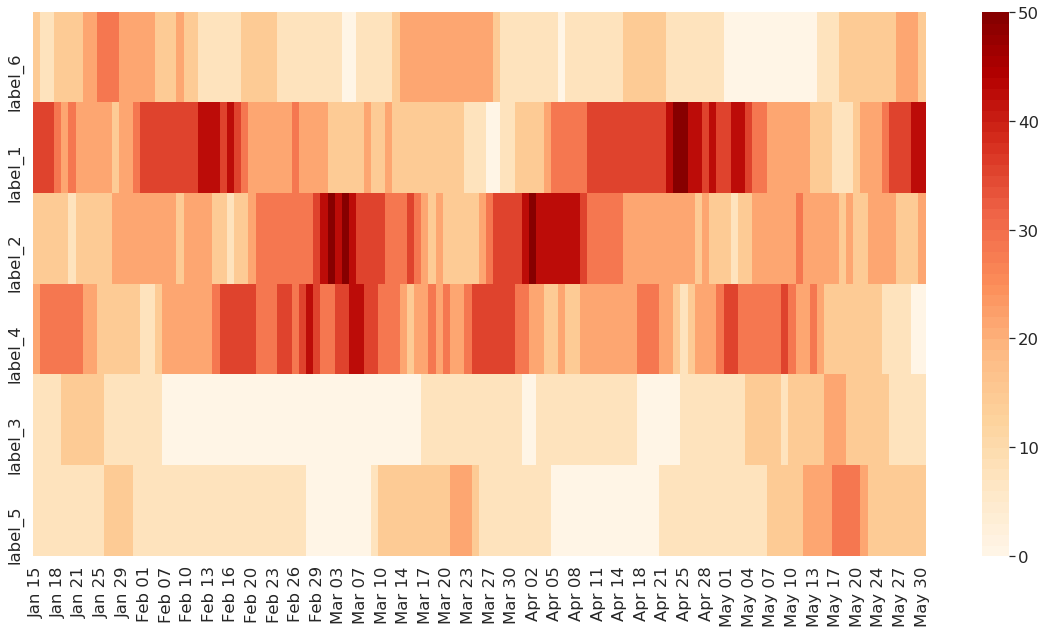

In [110]:
rolling_window_length = 14

df_heatmap = articles_per_day.copy()

for col in df_heatmap.columns:
    
    # Normalise the results
    m = max(df_heatmap[col].values)
    df_heatmap[col] = 100 * df_heatmap[col] / m
    
    # Apply rolling window
    df_heatmap[col] = df_heatmap[col].rolling(window=rolling_window_length).mean()

df_heatmap.index = pd.to_datetime(df_heatmap.index.values).strftime('%b %d')
df_heatmap = df_heatmap.iloc[rolling_window_length-1:, :]
df_heatmap = df_heatmap.T

sns.set(font_scale=1.5)
fig=plt.figure(figsize=(20, 10))

sns.heatmap(df_heatmap, cmap=sns.color_palette("OrRd", 50))

plt.savefig(f"{output_path}/plot_topic_{num_topics}.pdf")

## Experiment 3: Sentiments conveyed in the articles published every day, per topic.

In [111]:
sentiments = pd.read_csv(f"{output_path}/ws2_3_sentiment.csv")
sentiments.head()

,article_id,date,polarity,subjectivity
0,0,2020-01-01,0.011869,0.430303
1,1,2020-01-02,-0.336071,0.521190
2,2,2020-01-03,0.017754,0.332609
3,3,2020-01-04,-0.033333,0.425926
4,4,2020-01-05,0.046488,0.462913


In [113]:
articles_polarity = pd.merge(articles, sentiments[["article_id", "polarity"]], on="article_id", how="left")
articles_polarity = articles_polarity[['article_id', 'date', 'polarity', 'topic_label']]
articles_polarity.head()

,article_id,date,polarity,topic_label
0,0,2020-01-01,0.011869,label_6
1,1,2020-01-02,-0.336071,label_1
2,2,2020-01-03,0.017754,label_1
3,3,2020-01-04,-0.033333,label_1
4,4,2020-01-05,0.046488,label_2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff682383898>]],
      dtype=object)

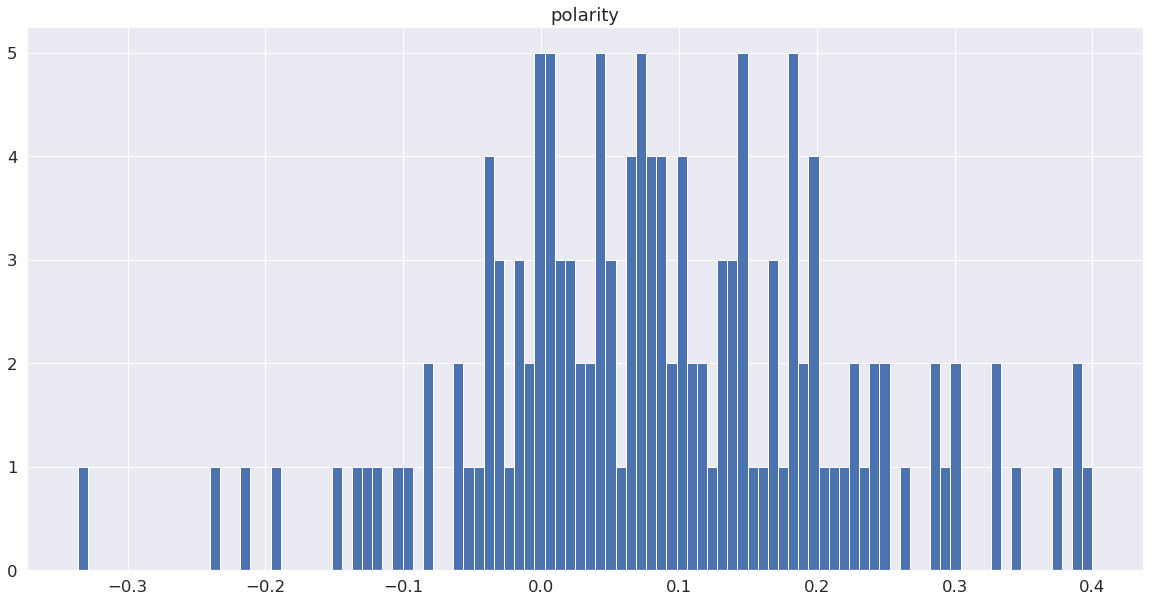

In [114]:
articles_polarity.hist("polarity", bins=100, figsize=(20, 10))

In [126]:
articles_per_day = articles_polarity[["date", "topic_label", "polarity"]].copy()
articles_per_day = articles_per_day.groupby(["date", "topic_label"]).agg({
    "polarity": lambda x: np.mean(list(x))
}).reset_index(drop=False)
articles_per_day.rename(columns={"polarity": "avg_polarity"}, inplace=True)

articles_per_day = articles_per_day.groupby("date").agg({
    "topic_label": lambda x: list(x),
    "avg_polarity": lambda x: list(x)
}).reset_index(drop=False)

articles_per_day["zip"] = articles_per_day.apply(lambda row: list(zip(row["topic_label"], row["avg_polarity"])), axis=1)

for topic_name in all_topics:
    articles_per_day[topic_name] = articles_per_day["zip"].apply(lambda x: [elem[1] for elem in x if elem[0] == topic_name])
    articles_per_day[topic_name] = articles_per_day[topic_name].apply(lambda x: x[0] if len(x) > 0 else 0)
articles_per_day.drop(["topic_label", "avg_polarity", "zip"], axis=1, inplace=True)

articles_per_day.set_index("date", drop=True, inplace=True)

articles_per_day.head()

,label_6,label_1,label_2,label_4,label_3,label_5
date,,,,,,
2020-01-01,0.011869,0.000000,0.000000,0.0,0.0,0.0
2020-01-02,0.000000,-0.336071,0.000000,0.0,0.0,0.0
2020-01-03,0.000000,0.017754,0.000000,0.0,0.0,0.0
2020-01-04,0.000000,-0.033333,0.000000,0.0,0.0,0.0
2020-01-05,0.000000,0.000000,0.046488,0.0,0.0,0.0


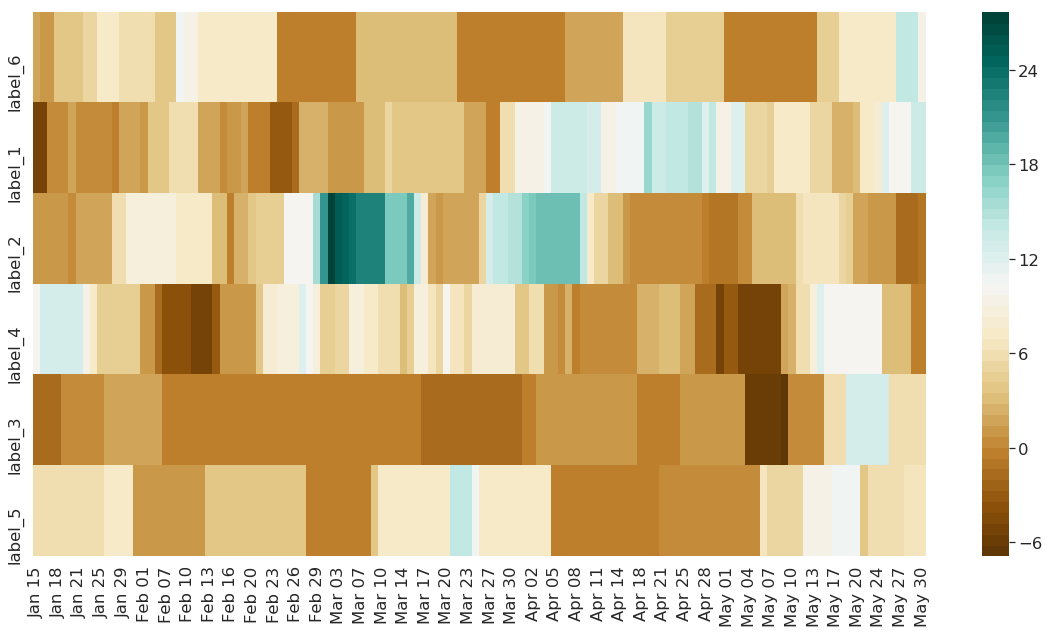

In [128]:
rolling_window_length = 14

df_heatmap = articles_per_day.copy()

for col in df_heatmap.columns:
    
    # Normalise the results
    m = max(df_heatmap[col].values)
    df_heatmap[col] = 100 * df_heatmap[col] / m
    
    # Apply rolling window
    df_heatmap[col] = df_heatmap[col].rolling(window=rolling_window_length).mean()

df_heatmap.index = pd.to_datetime(df_heatmap.index.values).strftime('%b %d')
df_heatmap = df_heatmap.iloc[rolling_window_length-1:, :]
df_heatmap = df_heatmap.T

sns.set(font_scale=1.5)
fig=plt.figure(figsize=(20, 10))

sns.heatmap(df_heatmap, cmap=sns.color_palette("BrBG", 50))

plt.savefig(f"{output_path}/plot_sentiments_{num_topics}.pdf")

#### Authors
  
* **Vincent Nelis** is Senior Data Scientist with Data Science & AI Elite team where he specializes in Data Science, Analytics platforms, and Machine Learning solutions.
* **Mehrnoosh Vahdat** is Data Scientist with Data Science & AI Elite team where she specializes in Data Science, Analytics platforms, and Machine Learning solutions.

Copyright © IBM Corp. 2020. Licensed under the Apache License, Version 2.0. Released as licensed Sample Materials.